# Features

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from PIL import Image
import wordcloud
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from pprint import pprint

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!pwd

/Users/chris/github/reddit_nlp


In [6]:
from util import databases
from util import dataloader
from util import grid_models
from util.reddit_functions import Reddit, Visualizer

In [7]:
!pwd

/Users/chris/github/reddit_nlp/util


In [8]:
# list to get data for
subreddit_list = ['datascience','machinelearning','dataengineering','python','aws']

# load data using dataloader module
df = dataloader.data_selector(subreddit_list, source='sqlite')

# what we expected?
df.sample(10)

Connection to SQLite DB successful


,title,subreddit,date
3784,Junior Python Developers...,python,2020-03-29
4907,Uploading .pem to EC2,aws,2020-04-02
6381,What's the reasoning behind modeling discrete ...,datascience,2020-04-02
13714,Advice on the transition from Microsoft to AWS,dataengineering,2020-04-10
6258,IBM data science course completion in 30 days,datascience,2020-04-02
11773,[N] Stanford is offering “CS472: Data Science ...,machinelearning,2020-04-10
3312,What low level language combines best with Pyt...,python,2020-03-29
2922,Want to make a ball bounce around the screen,python,2020-03-29
3215,Library for swagger documentation browsing and...,python,2020-03-29
12227,[Discussion] Do Deep Learning/Machine Learning...,machinelearning,2020-04-10


In [70]:
X = df['title']
y = df['subreddit']

In [78]:
label_encoder = LabelEncoder()
label_encoder.fit(y)
y = label_encoder.transform(y)
label_encoder.classes_

array(['aws', 'dataengineering', 'datascience', 'machinelearning',
       'python'], dtype=object)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [12]:
useless_words = set(['using', 'lambda', 's3', 'does', 'looking', 'help', 'new', 'data', 'science', 'machine', 'learning', 'use', 'need', 'engineer', 'engineering'])

custom_stop_words = ENGLISH_STOP_WORDS.union(subreddit_list, useless_words)

In [13]:
tfidf = TfidfVectorizer(max_df=0.7, max_features=6000, ngram_range=(1,2), stop_words=custom_stop_words)
svc = SVC()
pipe = Pipeline([('tfidf', tfidf),('svc', svc)])

In [14]:
model = pipe.fit(X_train, y_train)

Since GridSearch does automatic refit on the entire training set, we can use the transformer from this best model to make a features df

In [15]:
model.score(X_test, y_test)

0.9064507120915946

In [145]:
# use defined Visualizer to produce images
viz = Visualizer(df=df, text_column='title', labels_column='subreddit', model=model, transformer='tfidf')

In [ ]:
viz.plot_most_common(num_features=15, include_combined=True, standardize=True)

In [ ]:
###HELP### I don't think this is working right
###HELP### coefficients don't make sense for the entire dataset, would need to do one for each thing

In [ ]:
# ###NOTE### coefficients only for lr and etc etc etc...
# ###NOTE### coefficients only for two subreddits

# ### FIX ### look at the coef_ portion of the new single model instead of the gridsearch


# # [-1][1] for last step (estimator)(instantiation)
# # coef_[0]because I don't know why
# coefs = model.best_estimator_.steps[-1][1].coef_[0]




# plt.figure(figsize=(16, 12))
# plt.title('Feature Importance (Coefficients)', fontsize=20)
# plt.ylabel('Features', fontsize=18)
# plt.xlabel('(Abs) Coefficients', fontsize=18)

# coef_df = pd.DataFrame(data=[coefs], columns=features_columns).T
# coef_df['abs_coef'] = coef_df[0].abs()
# coef_df.sort_values('abs_coef', ascending=False)[0].head(15).plot(kind='barh');

# # coef_kill = coef_df.sort_values('abs_coef', ascending=False)[0].head(500).index

# # coef_kill


# # my_stops.extend(coef_kill)

In [ ]:
viz.plot_most_common_pairs(num_features=10)

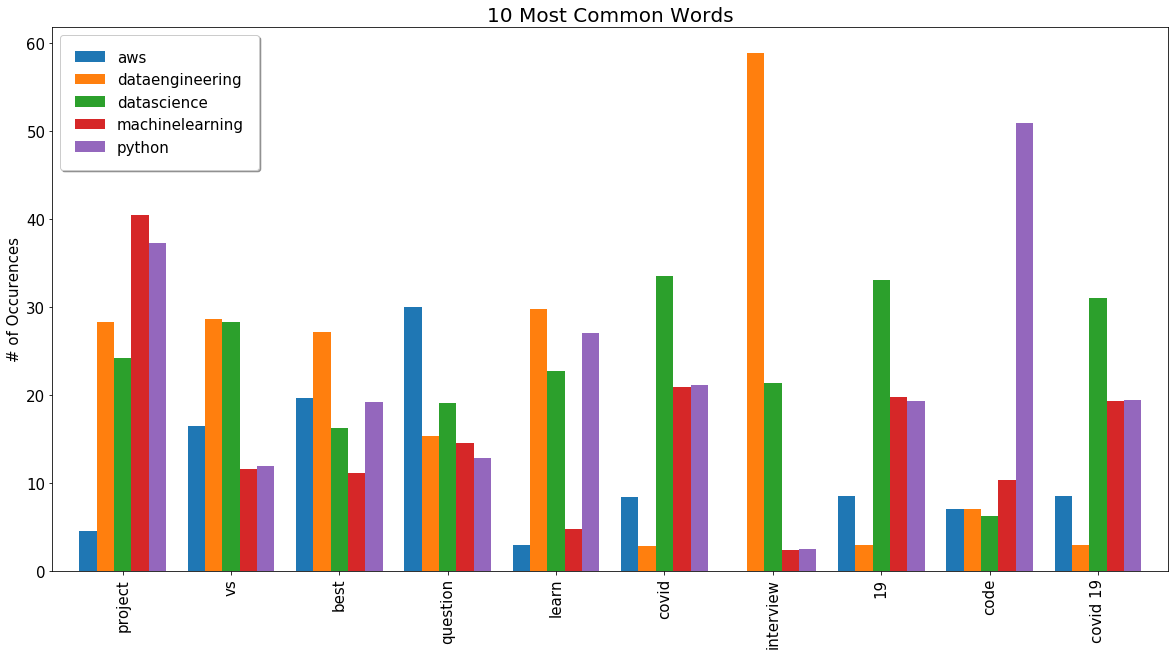

In [163]:
viz.plot_most_common_bar(num_features=10)

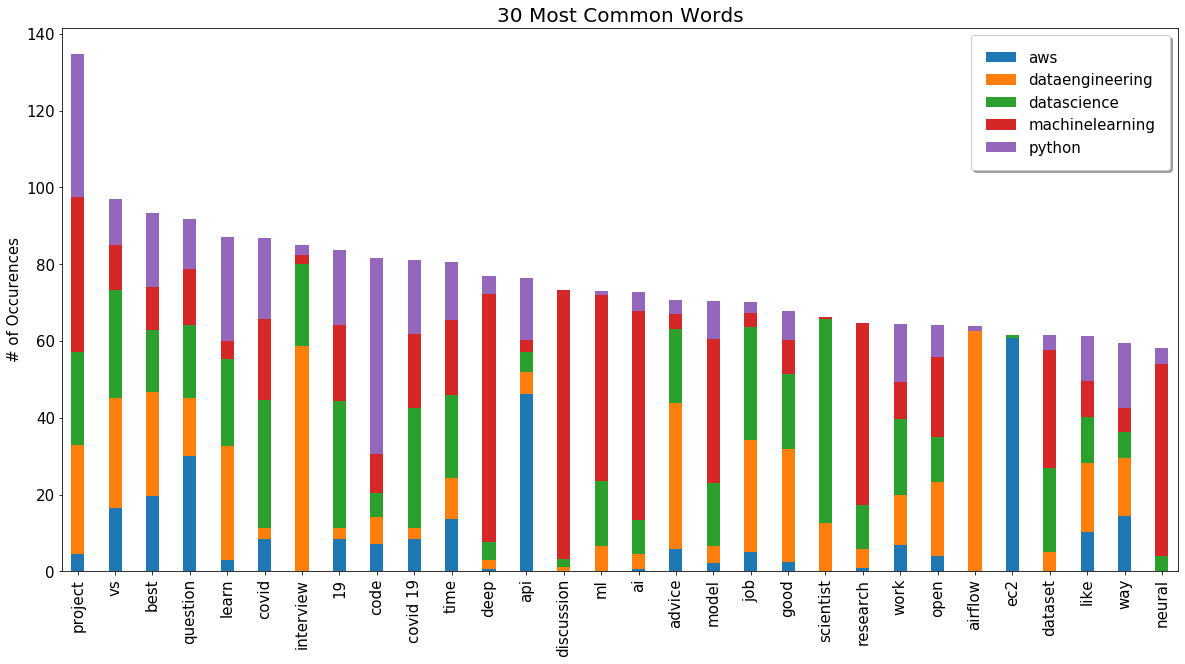

In [165]:
viz.plot_most_common_bar(num_features=30, stacked=True)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

In [ ]:
df_cm = pd.DataFrame(cm, columns=subreddit_list, index=subreddit_list)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
df_cm

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=2)
sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, cmap='Greens', ax=ax, )
fontdict={'fontsize': 16}
ax.set_yticklabels(labels=subreddit_list, rotation='horizontal', fontdict=fontdict)
ax.set_xticklabels(labels=subreddit_list, rotation=20, fontdict=fontdict)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

In [ ]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
mtn = mcm[:, 0, 0]
mtp = mcm[:, 1, 1]
mfn = mcm[:, 1, 0]
mfp = mcm[:, 0, 1]
print(mcm)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=len(subreddit_list),
                       figsize=(12, 6*len(subreddit_list)))

for i, cm in enumerate(mcm):
    df_cm = pd.DataFrame(cm)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, annot=True, fmt="d", cbar=False,
                cmap='Purples', ax=ax[i, 0])

    ax[i, 0].set_yticklabels(labels=[1, 0], rotation='horizontal')
    ax[i, 0].set_xticklabels(labels=[1, 0])
    ax[i, 0].xaxis.tick_top()
    ax[i, 0].xaxis.set_label_position('top')
    ax[i, 0].set_title(subreddit_list[i].upper())

    tn, fp, fn, tp = cm.ravel()
    specif = tn / (tn + fp)

    sens = tp / (tp + fn)
    box_text = f'''Subreddit: {subreddit_list[i].upper()}\n\nSpecificity: {round(specif,4)}\n\nSensitivity: {round(sens,4)}'''
    ax[i, 1].text(0.5, 0.5, box_text, horizontalalignment='center',
                  verticalalignment='center', fontsize=24)
    ax[i, 1].set_axis_off()


plt.tight_layout()

In [ ]:
print(classification_report(y_test, y_pred, digits=3, target_names=subreddit_list))

<h1>TODO:</h1>

1. Make it have the roc for each sub, have to get into the original df where subname equals indexes?
2. Plot confusion matrix
3. Make a notebook to test the confusion matrixes one by one with each individual model.

In [ ]:
y_test.index

In [ ]:
auc = roc_auc_score(y_test, y_pred)
auc

In [ ]:
probs = model.predict_proba(X_test)[:,1]

In [ ]:
# not multiclass
fpr, tpr, thresholds = roc_curve(y_test, probs)

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc})', color='r', marker='D')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve', size=20)
plt.legend(fontsize=14);

In [ ]:
x1 = np.random.normal(0, 0.8, 1000) x2 = np.random.normal(-2, 1, 1000) x3 = np.random.normal(3, 2, 1000)
kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)
plt.hist(x1, **kwargs) plt.hist(x2, **kwargs) plt.hist(x3, **kwargs);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(probs, bins=25, color='b')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
hst0 = plt.hist(probs[y_test == 0],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Technology',)

hst1 = plt.hist(probs[y_test == 1],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Science')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = max(hst1[0].max(), hst0[0].max()), # Max of the two highest respective hist values
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Science)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# Thanks to Matt Brems for the colorful graphs! :)